A91147501 Nichakarn Ratanaphaithun  
A12108176  
A12118052  

# Introduction
In 2015, the City of San Diego conducted a resident satisfaction survey that assessed various aspects of living in San Diego. Residents provided an overall rating of the city of San Diego as a place to live as well as satisfaction ratings on specific city services and programs. 

By exploring these responses, we hope to find the most common causes of resident dissatisfaction and which neighborhoods they are most prominent in. As students of UC San Diego in the affluent La Jolla neighborhood, we have become accustomed to living inside a “bubble” of privilege, but as members of the community, we believe that uncovering these truths will be useful to future development plans for the university and the city.

#### Research Question:
What factors of living in San Diego contribute most to resident dissatisfaction? What kinds of neighborhoods are unsatisfactory, and why?

#### Hypothesis:
We predict that residents in communities with lower housing prices will have lower overall resident satisfaction. We hypothesize that factors such as the proximity to different resources and the maintenance of services the city provides correlate with resident satisfaction.

# Data Set Descriptions

<b>Name</b>: Resident Satisfaction Survey Results  
<b>Link to the dataset:</b> https://data.sandiego.gov/datasets/resident-satisfaction-survey/  
<b>Number of observations:</b> 2478  
<b>Description:</b> This dataset contains the results of 2,478 surveys conducted on San Diego residents. The survey assessed satisfaction with the delivery of City programs, services, staff and preferences about how City officials should prioritize programs and services. Each survey contained 28 questions and the zip code of each respondent is provided.

<b>Name:</b> Median Housing Prices by Zip Code  
<b>Link to the dataset:</b> https://query.data.world/s/4YkmYcRnpcRqTmJ9qWn5KRALu157jX  
<b>Description:</b> This dataset contains the monthly median housing prices of listings on Zillow, the leading online real estate database. We recognize tha

# Imports

In [88]:
%matplotlib inline

from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Background
We first addressed the main crux of our research question with the exploration of income. Since housing prices are an indicator of income in a certain neighborhood, we utilized San Diego's median housing prices in 2017-09 (September of 2017), visualized in a histogram to see the distribution of prices. As demonstrated by the skewness and non-normal distribution, there is a large amount of cheaper houses. This hints to a gap between high income communities and low-income ones in the San Diego county.

In [89]:
#Read in income data
avg_house_prices = pd.read_csv('https://query.data.world/s/4YkmYcRnpcRqTmJ9qWn5KRALu157jX')
avg_house_prices = avg_house_prices[avg_house_prices['CountyName'] == 'San Diego'] 

#Extract zipcode, city, 2015-01 column
avg_house_prices = avg_house_prices[['RegionName', 'City', '2015-01']]
avg_house_prices.dropna(inplace=True)

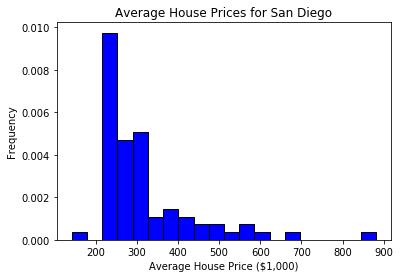

In [90]:
#Plot histogram of avg house prices
histogram = plt.hist(avg_house_prices['2015-01'], 20, edgecolor='black', facecolor='blue',normed=1)
plt.xlabel('Average House Price ($1,000)')
plt.ylabel('Frequency')
plt.title('Average House Prices for San Diego')

f1 = plt.gcf()

# Data Cleaning
In the survey results, we first explored the different answers to gain a better understanding of what we can achieve in terms of analysis later on. We realized that there were a variety of questions which led to a inconsistent answers. Some of them were quantitive, as in respondants answered questioned based on a scale from 1 to 5, with 1 being the most disatistfied. Others were qualitative, which each answer specified to, for example, a certain income bracket. As such, we had to eliminate all the questions with responses that weren't pertaining to satisfaction/dissatisfaction.

In [91]:
#Original df
df = pd.read_csv("resident_survey_weighted_datasd.csv")

#Create new df (data) that we will drop columns from
data = pd.read_csv("resident_survey_weighted_datasd.csv")

data.head()

,Num,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q2_1,Q2_2,Q2_3,...,Q25_1st,Q25_2nd,Q25_3rd,Q25_4th,Q25_5th,Q25_other,Q26,Q27,Q28,ZIP
0,1,5,4,4,3,3,3,4,5,3,...,3,NaN,NaN,NaN,NaN,NaN,2,2,7,92124
1,2,5,5,9,3,4,5,3,3,4,...,5,NaN,NaN,NaN,NaN,NaN,1,1,9,92115
2,3,4,3,4,4,4,5,4,4,4,...,1,NaN,NaN,NaN,NaN,NaN,1,1,9,92105
3,4,4,4,4,3,3,2,2,1,2,...,5,NaN,NaN,NaN,NaN,NaN,2,2,8,92102
4,5,5,5,5,4,5,5,5,5,4,...,3,NaN,NaN,NaN,NaN,NaN,2,2,4,92139


In [92]:
#Extract questions that ask residents to rate their satisfaction on a topic from 1-5
data.drop(data.columns[99:], axis=1, inplace=True)
data.drop(data.columns[0:7], axis=1, inplace=True)
#data.head(5)

data.drop(data.filter(like='Q4', axis=1), axis=1, inplace=True)
data.drop(data.filter(like='Q5', axis=1), axis=1, inplace=True)
data.drop(data.filter(like='Q10', axis=1), axis=1, inplace=True)
#data.head(5)

In [93]:
#Find total surveys submitted per zip code
total_zip = pd.DataFrame(df['ZIP'].value_counts())

#Only keep zipcodes who submitted more than 20 surveys
total_zip = total_zip[total_zip['ZIP'] > 20]

#Convert total_zip to a dataframe, tell me if yall know a better way to do this
total_zip.index.name = 'x'
total_zip.reset_index(inplace=True)
total_zip.columns = ['ZIP', 'count']

#Add zipcode column back into data
data['ZIP'] = df['ZIP']

#Drop all rows whose zipcode has <20 surveys
data = data[data['ZIP'].isin(total_zip['ZIP'])].dropna()

#Convert 9s (meaning "don't know") to NaNs
data.replace(9, np.nan, inplace=True)

data.head(10)


,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q3_1,Q3_2,Q3_3,...,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q15_2,Q15_3,Q15_4,ZIP
0,4.0,5.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,3.0,...,3.0,4.0,NaN,NaN,3.0,4.0,4.0,4.0,4.0,92124
1,3.0,3.0,4.0,4.0,5.0,5.0,5.0,3.0,4.0,5.0,...,3.0,4.0,3.0,2.0,3.0,5.0,4.0,5.0,4.0,92115
2,4.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,...,5.0,5.0,5.0,3.0,4.0,4.0,4.0,4.0,5.0,92105
3,2.0,1.0,2.0,4.0,4.0,4.0,2.0,4.0,3.0,3.0,...,2.0,4.0,4.0,2.0,3.0,3.0,4.0,3.0,3.0,92102
4,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,...,4.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,92139
5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,92101
7,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,92131
8,4.0,4.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,...,3.0,4.0,NaN,3.0,2.0,4.0,4.0,4.0,4.0,92117
9,4.0,3.0,2.0,4.0,3.0,3.0,1.0,3.0,4.0,3.0,...,3.0,3.0,1.0,3.0,2.0,2.0,3.0,2.0,1.0,92114
10,4.0,3.0,2.0,4.0,3.0,3.0,1.0,3.0,4.0,3.0,...,3.0,3.0,1.0,3.0,2.0,2.0,3.0,2.0,1.0,92114


In [94]:
#Get bottom 10 questions with lowest avg rating per zipcode
mean = data.mean()
bottom_10 = mean.nsmallest(n=10, keep='first')
print(bottom_10)

Q14_3     2.305689
Q3_8      2.393837
Q8_3      2.432886
Q14_14    2.565351
Q8_10     2.578723
Q14_4     2.584436
Q8_4      2.633361
Q14_5     2.645178
Q14_6     2.692648
Q14_2     2.694984
dtype: float64


In [95]:
#Read in survey questions
questions = pd.read_csv("resident_survey_dictionary_datasd.csv")

In [96]:
#Locate the questions
Q1 = (questions.loc[questions['question_number']=='Q14_3'])['question_text']
Q2 = (questions.loc[questions['question_number']=='Q3_8'])['question_text']
Q3 = (questions.loc[questions['question_number']=='Q8_3'])['question_text']
Q4 = (questions.loc[questions['question_number']=='Q14_14'])['question_text']
Q5 = (questions.loc[questions['question_number']=='Q14_4'])['question_text']
Q6 = (questions.loc[questions['question_number']=='Q8_10'])['question_text']
Q7 = (questions.loc[questions['question_number']=='Q8_4'])['question_text']
Q8 = (questions.loc[questions['question_number']=='Q14_5'])['question_text']
Q9 = (questions.loc[questions['question_number']=='Q14_6'])['question_text']
Q10 = (questions.loc[questions['question_number']=='Q14_2'])['question_text']
Q11 = (questions.loc[questions['question_number']=='Q14_1'])['question_text']


print(Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11)

95    Ease of obtaining permits from Development Ser...
Name: question_text, dtype: object 23    Maintenance of City streets, sidewalks, and in...
Name: question_text, dtype: object 54    Condition and maintenance of City streets
Name: question_text, dtype: object 106    Quality/variety of entertainment, expositions,...
Name: question_text, dtype: object 96    Efforts to address homelessness
Name: question_text, dtype: object 61    Quality of street repairs
Name: question_text, dtype: object 55    Condition and maintenance of streets in YOUR n...
Name: question_text, dtype: object 97    Efforts to assist low- to moderate-income resi...
Name: question_text, dtype: object 98    Efforts to plan for future growth
Name: question_text, dtype: object 94    Code enforcement
Name: question_text, dtype: object 93    Blight (rundown buildings, vacant lots, and ab...
Name: question_text, dtype: object


## Factor #1: Street and road conditions

Out of the 10 questions with the lowest satisfaction scores, 4 of them concerned street and road conditions, specifically the condition, maintenance and repairs. We plotted the average rating (on a scale from 1 to 5) with the the average house price associated with the respondent in order to determine any correlation between their level of satisfaction and their income level.

In [97]:
#Extract street questions and zipcodes out of the top 10 
street_qs = data[['Q8_3', 'Q3_8', 'Q8_4', 'Q8_10', 'ZIP']]
#street_qs

In [98]:
#Find average rating on all questions for each zip code

avg_ratings_per_zip = street_qs.groupby('ZIP', as_index=False).mean()
#

#FOR GEOGRAPH: Extract 5 zipcodes with lowest average rating
lowest_q83 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_3',keep='first')[['ZIP','Q8_3']]
lowest_q38 = avg_ratings_per_zip.nsmallest(n=5, columns='Q3_8',keep='first')[['ZIP','Q3_8']]
lowest_q84 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_4',keep='first')[['ZIP','Q8_4']]
lowest_q810 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_10',keep='first')[['ZIP','Q8_10']]


#avg_ratings_per_zip.head()

In [99]:
#Add avg house prices 2017-09 data to ratings data
rating_and_price = avg_ratings_per_zip.merge(avg_house_prices, left_on='ZIP', right_on='RegionName')

#Compute correlation between avg rating and avg house price for each question
Q8_3_corr = rating_and_price['Q8_3'].corr(rating_and_price['2015-01'])
Q3_8_corr = rating_and_price['Q3_8'].corr(rating_and_price['2015-01'])
Q8_4_corr = rating_and_price['Q8_4'].corr(rating_and_price['2015-01'])
Q8_10_corr = rating_and_price['Q8_10'].corr(rating_and_price['2015-01'])

print(Q8_3_corr,Q3_8_corr,Q8_4_corr,Q8_10_corr)

-0.206489021822 -0.219789539811 -0.114843878167 -0.0324363744786


Our initial data analysis computes the Pearson correlation coefficient between lowest question that concern streets's average rating and average housing price. With coefficient values not close to 1 or -1, we initially conclude that there is no significant correlation between the resident's income and satisfaction level.

Text(0.5,1,'Satisfaction with Condition/Maintenance of SD Streets vs. Avg House Price')

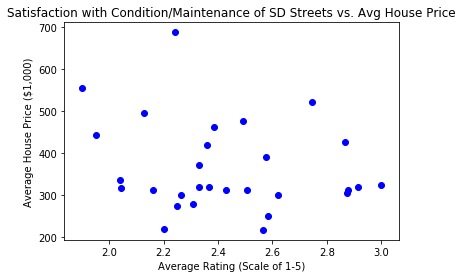

In [100]:
#Plot scatterplot of avg rating vs avg house price
Q8_3_scatter = plt.scatter(rating_and_price['Q8_3'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price ($1,000)')
plt.title('Satisfaction with Condition/Maintenance of SD Streets vs. Avg House Price')

Text(0.5,1,'Satisfaction with Maintenance of SD Streets/Sidewalks/Infrastructure vs Avg House Price')

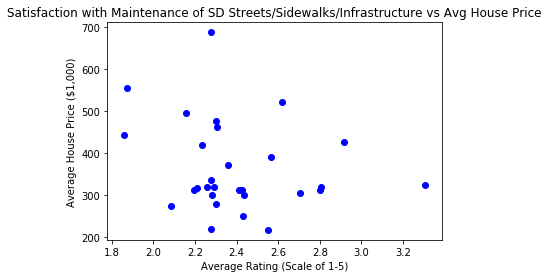

In [101]:
Q3_8_scatter = plt.scatter(rating_and_price['Q3_8'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price ($1,000)')
plt.title('Satisfaction with Maintenance of SD Streets/Sidewalks/Infrastructure vs Avg House Price')

Text(0.5,1,'Satisfaction with Condition/maintenance of streets in YOUR neighborhood vs. Average House Price')

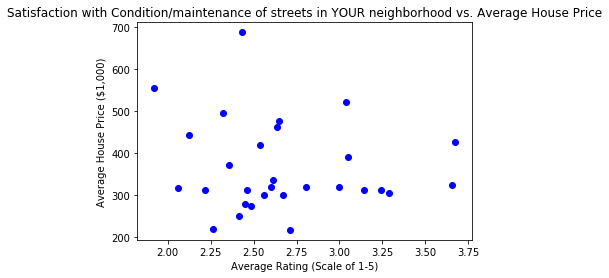

In [102]:
Q8_4_scatter = plt.scatter(rating_and_price['Q8_4'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price ($1,000)')
plt.title('Satisfaction with Condition/maintenance of streets in YOUR neighborhood vs. Average House Price')

Text(0.5,1,'Satisfaction with Quality of street repairs vs. Avg House Price')

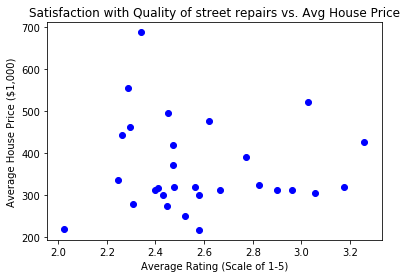

In [103]:
Q8_10_scatter = plt.scatter(rating_and_price['Q8_10'], rating_and_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price ($1,000)')
plt.title('Satisfaction with Quality of street repairs vs. Avg House Price')

We've visualized the median housing prices below as well as the corresponding ratings for each zip code through geomaps. For housing prices, the darker the shade, the more expensive the houses while for the question-specific maps, the darker the shade, the more satisfied they are.

In [104]:
%%HTML
<script type='text/javascript'src='https://us-west-2b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1280px; height: 525px;'><object class='tableauViz' width='1280' height='525' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-west-2b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;cogs108' /><param name='name' value='avg_ratings_geomaps&#47;2015HousePrices' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

# Results
Through both our mathematical and visual analysis of data correlation, we see that there is none between the income level and the level of satisfaction residents have about their street conditions. This is perhaps because the prevalence of deteriorated and poor road conditions is so widespread that it affects a wide number of commuter in San Diego, not exclusively to just low-income neighborhoods.

# Factor #2: Efforts to help and assist homelessness and low- to moderate-income residents
Two other questions that stood out to us in terms of resident disatisfaction is concerning the City of San Diego's efforts to address homelessness and assist low- to moderate-income residents. We coupled these two questions together since they both concern the communities that are usually underserved. After seeing no correlation between how a resident's income level and their level of satisfaction with their road conditions, we predicted that there would be a positive correlation between how satisfied a resident is about the city's efforts to assist the underserved and their income. This would mean that residents with lower-income would be more dissatisfied about the city's efforts to assist their communities or homelessness.

In [105]:
#Extract Q14_4 and Q_14_5 (Efforts to address homelessness and Efforts to assist low- to moderate-income residents and communities)
low_income = data[['Q14_4', 'Q14_5', 'ZIP']]

avg_ratings = low_income.groupby('ZIP', as_index=False).mean()
lowest_q144 = avg_ratings.nsmallest(n=5, columns='Q14_4',keep='first')[['ZIP','Q14_4']]
lowest_q145 = avg_ratings.nsmallest(n=5, columns='Q14_5',keep='first')[['ZIP','Q14_5']]
print(lowest_q144, lowest_q145)

      ZIP     Q14_4
10  92110  1.844444
15  92116  2.097561
9   92109  2.181818
2   92102  2.193548
6   92106  2.222222       ZIP     Q14_5
8   92108  2.285714
15  92116  2.304348
10  92110  2.317073
3   92103  2.358974
11  92111  2.405063


In [106]:
rating_price = avg_ratings.merge(avg_house_prices, left_on='ZIP', right_on='RegionName')
#rating_price.head()
#Compute correlation between avg rating and avg house price for each question
Q14_4_corr = rating_price['Q14_4'].corr(rating_price['2015-01'])
Q14_5_corr = rating_price['Q14_5'].corr(rating_price['2015-01'])

print(Q14_4_corr, Q14_5_corr)

-0.205025499481 -0.254438483501


Our initial pearson correlation analysis indicates that there is not a significant relationship between the average rating of satisfication, concerning efforts to assist the underserved, and the resident's income.

Text(0.5,1,'Satisfaction with Efforts to Address Homelessness vs. Avg House Price')

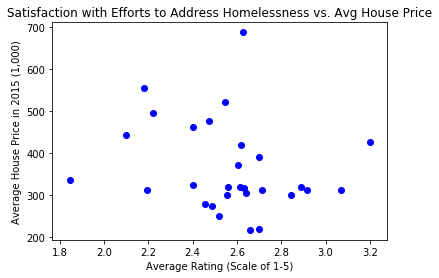

In [107]:
Q14_4_scatter = plt.scatter(rating_price['Q14_4'], rating_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 (1,000)')
plt.title('Satisfaction with Efforts to Address Homelessness vs. Avg House Price')

Text(0.5,1,'Satisfaction with Efforts to Assist Low to Moderate-Income Residents vs. Avg House Price')

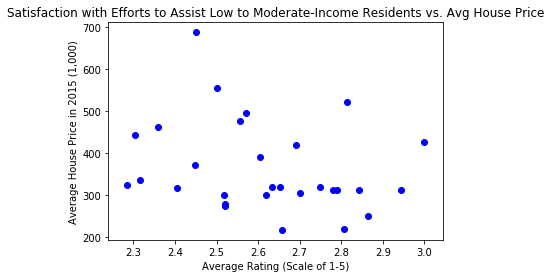

In [108]:
Q14_5_scatter = plt.scatter(rating_price['Q14_5'], rating_price['2015-01'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price in 2015 (1,000)')
plt.title('Satisfaction with Efforts to Assist Low to Moderate-Income Residents vs. Avg House Price')

# Results
Through our correlation and visual data analysis, we conclude that while there some correlation between a resident's satisfaction with the city's efforts to assist the underserved and their income, surprisingly a negative one, it is not statistically significant to conclude any real relationship. This hint to a negative correlation indicates that there are some residents from higher-income backgrounds that are disatisfied with current SD County's programs and intitiatives to aid lower-income residents and communities.